# exp007_tag_features エラー分析と今後の改善方針

## 概要
- **実験**: exp007_tag_features
- **CV MAPE**: 13.62%
- **改善幅**: 0.57pt (exp006: 14.19% → 13.62%)
- **目標達成**: ✓ (< 14.0%)

In [1]:
import sys
from pathlib import Path

# プロジェクトルートを設定
project_root = Path().resolve().parents[2]
sys.path.insert(0, str(project_root / "04_src"))

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# seabornのスタイル設定を先に行う
sns.set_style('whitegrid')

# 日本語フォント設定 (macOS) - seabornの後に設定
# Hiragino Sansを直接指定
plt.rcParams['font.family'] = 'Hiragino Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# フォント確認
print(f"使用フォント: {plt.rcParams['font.family']}")
print("ライブラリ読み込み完了")

使用フォント: ['Hiragino Sans']
ライブラリ読み込み完了


## 1. データ読み込み

In [2]:
# OOF予測データ読み込み
oof_path = project_root / "06_experiments/exp007_tag_features/outputs/oof_predictions_20251126_090710.csv"
oof_df = pl.read_csv(oof_path)

# Feature importance読み込み
importance_path = project_root / "06_experiments/exp007_tag_features/outputs/feature_importance_20251126_090710.csv"
importance_df = pl.read_csv(importance_path)

print(f"OOF予測データ: {oof_df.shape}")
print(f"特徴量重要度: {importance_df.shape}")
oof_df.head()

OOF予測データ: (363924, 3)
特徴量重要度: (164, 2)


id,actual,predicted
i64,i64,f64
0,13980000,1.5981e7
1,24480000,2.1114e7
2,24480000,2.2353e7
3,16300000,2.2544e7
4,18800000,1.7846e7


In [3]:
# エラー計算
oof_df = oof_df.with_columns([
    (pl.col("predicted") - pl.col("actual")).alias("error"),
    ((pl.col("predicted") - pl.col("actual")).abs() / pl.col("actual") * 100).alias("ape"),  # Absolute Percentage Error
    ((pl.col("predicted") - pl.col("actual")) / pl.col("actual") * 100).alias("pe"),  # Percentage Error (signed)
])

# 基本統計
print("=" * 60)
print("エラー統計")
print("=" * 60)
print(f"MAPE: {oof_df['ape'].mean():.4f}%")
print(f"MAE: {oof_df['error'].abs().mean():,.0f}円")
print(f"RMSE: {np.sqrt((oof_df['error']**2).mean()):,.0f}円")
print(f"平均予測誤差 (バイアス): {oof_df['error'].mean():,.0f}円")
print(f"中央値APE: {oof_df['ape'].median():.4f}%")

エラー統計
MAPE: 13.6199%
MAE: 3,206,882円
RMSE: 5,512,742円
平均予測誤差 (バイアス): -482,635円
中央値APE: 9.4401%


## 2. 予測誤差の分布

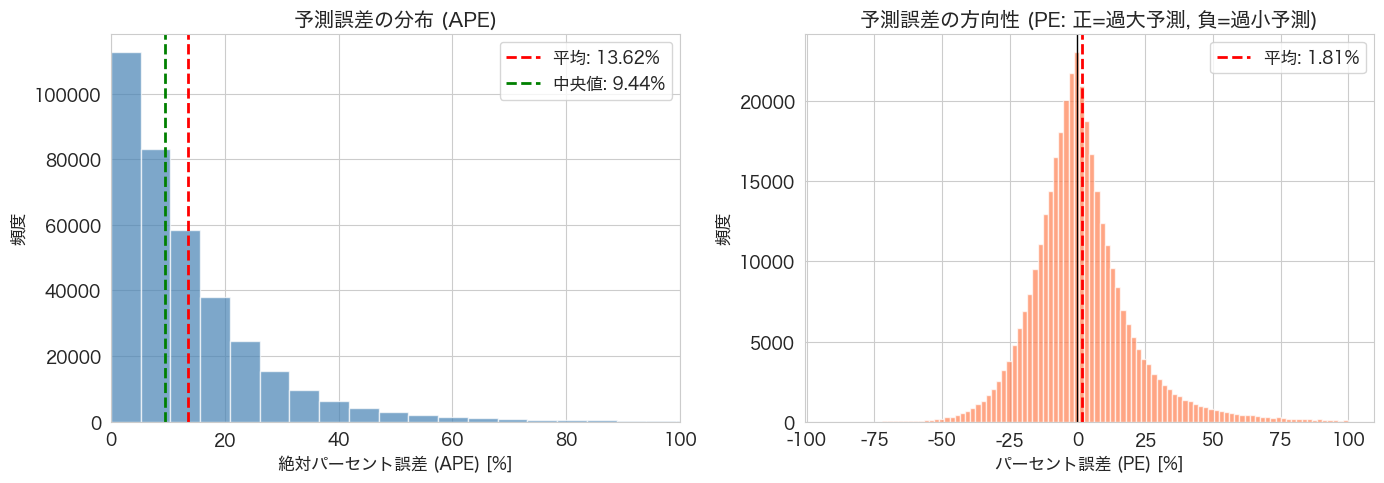


過大予測の割合: 48.8%
過小予測の割合: 51.2%


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# APE分布
ax1 = axes[0]
ape_data = oof_df['ape'].to_numpy()
ax1.hist(ape_data, bins=100, edgecolor='white', alpha=0.7, color='steelblue')
ax1.axvline(ape_data.mean(), color='red', linestyle='--', linewidth=2, label=f'平均: {ape_data.mean():.2f}%')
ax1.axvline(np.median(ape_data), color='green', linestyle='--', linewidth=2, label=f'中央値: {np.median(ape_data):.2f}%')
ax1.set_xlabel('絶対パーセント誤差 (APE) [%]')
ax1.set_ylabel('頻度')
ax1.set_title('予測誤差の分布 (APE)')
ax1.legend()
ax1.set_xlim(0, 100)  # 100%以下に制限

# 誤差方向の分布 (PE)
ax2 = axes[1]
pe_data = oof_df['pe'].to_numpy()
# 外れ値を除外 (-100% ~ +100%)
pe_clipped = pe_data[(pe_data >= -100) & (pe_data <= 100)]
ax2.hist(pe_clipped, bins=100, edgecolor='white', alpha=0.7, color='coral')
ax2.axvline(0, color='black', linestyle='-', linewidth=1)
ax2.axvline(pe_data.mean(), color='red', linestyle='--', linewidth=2, label=f'平均: {pe_data.mean():.2f}%')
ax2.set_xlabel('パーセント誤差 (PE) [%]')
ax2.set_ylabel('頻度')
ax2.set_title('予測誤差の方向性 (PE: 正=過大予測, 負=過小予測)')
ax2.legend()

plt.tight_layout()
plt.savefig('../outputs/error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n過大予測の割合: {(pe_data > 0).mean()*100:.1f}%")
print(f"過小予測の割合: {(pe_data < 0).mean()*100:.1f}%")

## 3. 実価格帯別のエラー分析

In [5]:
# 価格帯の定義 (万円)
price_bins = [0, 500, 1000, 1500, 2000, 3000, 5000, 10000, float('inf')]
price_labels = ['~500万', '500-1000万', '1000-1500万', '1500-2000万', '2000-3000万', '3000-5000万', '5000万-1億', '1億~']

# 価格帯カラム追加
actual_manyen = oof_df['actual'].to_numpy() / 10000  # 万円に変換
price_band = pd.cut(actual_manyen, bins=price_bins, labels=price_labels)
oof_pdf = oof_df.to_pandas()
oof_pdf['price_band'] = price_band

# 価格帯別統計
price_stats = oof_pdf.groupby('price_band', observed=True).agg({
    'ape': ['mean', 'median', 'std', 'count'],
    'pe': 'mean'
}).round(2)
price_stats.columns = ['平均APE(%)', '中央値APE(%)', 'APE標準偏差', 'サンプル数', '平均PE(%)']
print("価格帯別エラー統計:")
print(price_stats)

価格帯別エラー統計:
            平均APE(%)  中央値APE(%)  APE標準偏差  サンプル数  平均PE(%)
price_band                                              
~500万          38.81      25.65    43.84   2573    38.47
500-1000万      21.92      13.39    26.20  46734    17.48
1000-1500万     14.59      10.38    15.37  58078     4.42
1500-2000万     12.83       9.61    12.25  62004     1.03
2000-3000万     11.29       8.60    10.38  93654    -1.50
3000-5000万     10.76       8.17     9.88  74894    -3.60
5000万-1億       12.07       9.19    10.75  22666    -5.49
1億~            15.95      11.97    14.37   3321   -12.66


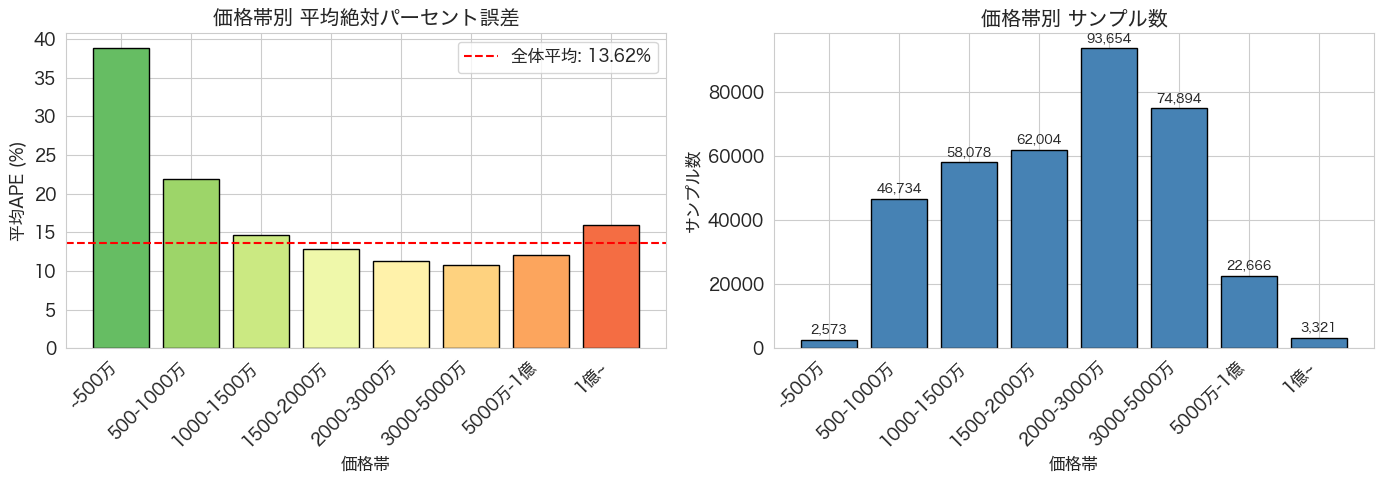

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 価格帯別MAPE
ax1 = axes[0]
price_order = price_labels
mape_by_band = oof_pdf.groupby('price_band', observed=True)['ape'].mean().reindex(price_order)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(mape_by_band)))
bars = ax1.bar(range(len(mape_by_band)), mape_by_band.values, color=colors, edgecolor='black')
ax1.set_xticks(range(len(mape_by_band)))
ax1.set_xticklabels(price_order, rotation=45, ha='right')
ax1.set_xlabel('価格帯')
ax1.set_ylabel('平均APE (%)')
ax1.set_title('価格帯別 平均絶対パーセント誤差')
ax1.axhline(oof_pdf['ape'].mean(), color='red', linestyle='--', label=f'全体平均: {oof_pdf["ape"].mean():.2f}%')
ax1.legend()

# 価格帯別サンプル数
ax2 = axes[1]
count_by_band = oof_pdf.groupby('price_band', observed=True).size().reindex(price_order)
ax2.bar(range(len(count_by_band)), count_by_band.values, color='steelblue', edgecolor='black')
ax2.set_xticks(range(len(count_by_band)))
ax2.set_xticklabels(price_order, rotation=45, ha='right')
ax2.set_xlabel('価格帯')
ax2.set_ylabel('サンプル数')
ax2.set_title('価格帯別 サンプル数')

# サンプル数をバーの上に表示
for i, v in enumerate(count_by_band.values):
    ax2.text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../outputs/error_by_price_band.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. 実測値 vs 予測値のプロット

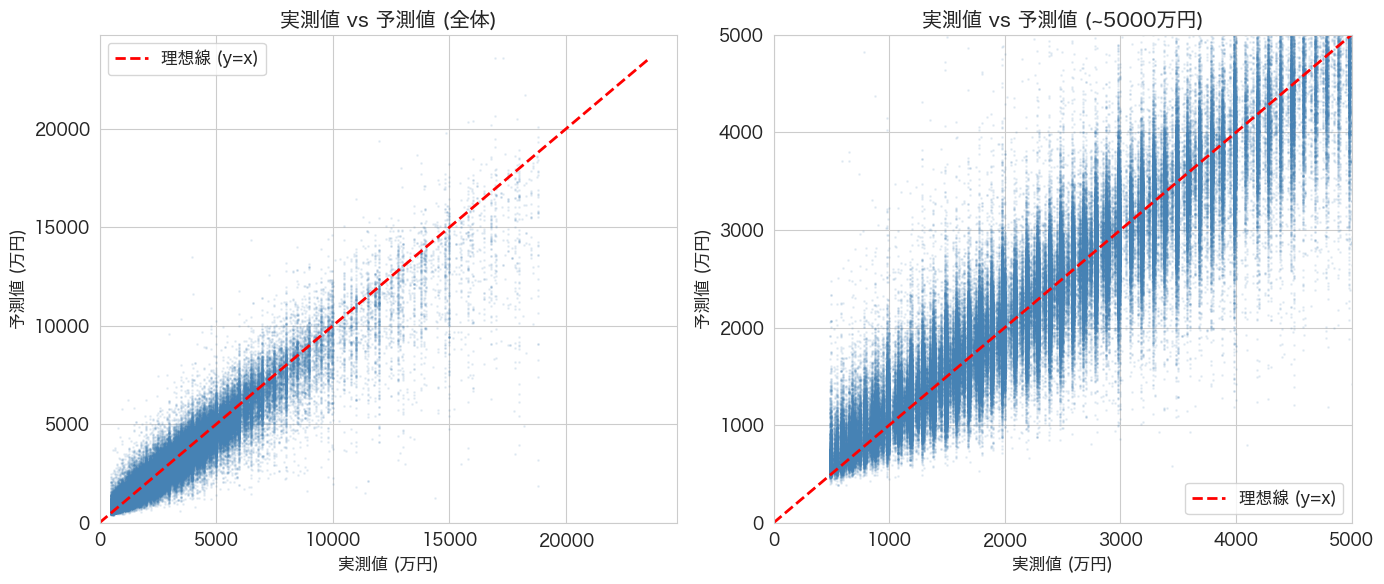

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

actual = oof_df['actual'].to_numpy() / 10000  # 万円
predicted = oof_df['predicted'].to_numpy() / 10000  # 万円

# 全体プロット
ax1 = axes[0]
ax1.scatter(actual, predicted, alpha=0.1, s=1, c='steelblue')
max_val = max(actual.max(), predicted.max())
ax1.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='理想線 (y=x)')
ax1.set_xlabel('実測値 (万円)')
ax1.set_ylabel('予測値 (万円)')
ax1.set_title('実測値 vs 予測値 (全体)')
ax1.legend()
ax1.set_xlim(0, max_val * 1.05)
ax1.set_ylim(0, max_val * 1.05)

# 低価格帯に絞ったプロット (0-5000万円)
ax2 = axes[1]
mask = (actual <= 5000) & (predicted <= 5000)
ax2.scatter(actual[mask], predicted[mask], alpha=0.1, s=1, c='steelblue')
ax2.plot([0, 5000], [0, 5000], 'r--', linewidth=2, label='理想線 (y=x)')
ax2.set_xlabel('実測値 (万円)')
ax2.set_ylabel('予測値 (万円)')
ax2.set_title('実測値 vs 予測値 (~5000万円)')
ax2.legend()
ax2.set_xlim(0, 5000)
ax2.set_ylim(0, 5000)

plt.tight_layout()
plt.savefig('../outputs/actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. 高エラーサンプルの分析

In [8]:
# APE上位10%のサンプル
high_error_threshold = oof_df['ape'].quantile(0.9)
high_error_df = oof_df.filter(pl.col('ape') > high_error_threshold)

print(f"高エラーサンプル (APE > {high_error_threshold:.1f}%): {len(high_error_df):,}件 ({len(high_error_df)/len(oof_df)*100:.1f}%)")
print(f"\n高エラーサンプルの統計:")
print(f"  平均APE: {high_error_df['ape'].mean():.2f}%")
print(f"  平均実測値: {high_error_df['actual'].mean()/10000:,.0f}万円")
print(f"  平均予測値: {high_error_df['predicted'].mean()/10000:,.0f}万円")

高エラーサンプル (APE > 29.4%): 36,392件 (10.0%)

高エラーサンプルの統計:
  平均APE: 47.41%
  平均実測値: 2,046万円
  平均予測値: 2,091万円


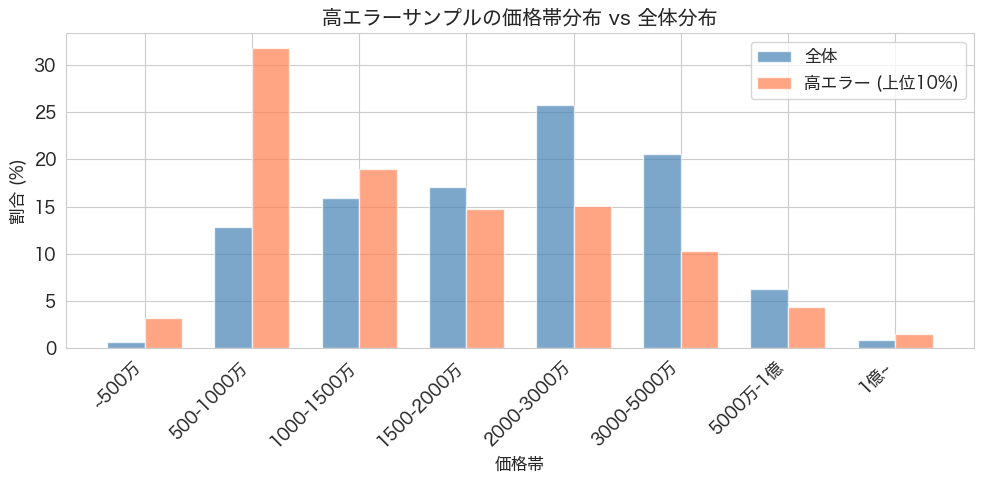

In [9]:
# 高エラーサンプルの価格帯分布
high_error_pdf = high_error_df.to_pandas()
high_error_actual = high_error_pdf['actual'].values / 10000
high_error_band = pd.cut(high_error_actual, bins=price_bins, labels=price_labels)
high_error_pdf['price_band'] = high_error_band

fig, ax = plt.subplots(figsize=(10, 5))

# 高エラーの価格帯分布 vs 全体分布
all_dist = oof_pdf.groupby('price_band', observed=True).size() / len(oof_pdf) * 100
high_error_dist = high_error_pdf.groupby('price_band', observed=True).size() / len(high_error_pdf) * 100

x = np.arange(len(price_labels))
width = 0.35

bars1 = ax.bar(x - width/2, all_dist.reindex(price_labels).fillna(0), width, label='全体', color='steelblue', alpha=0.7)
bars2 = ax.bar(x + width/2, high_error_dist.reindex(price_labels).fillna(0), width, label='高エラー (上位10%)', color='coral', alpha=0.7)

ax.set_xlabel('価格帯')
ax.set_ylabel('割合 (%)')
ax.set_title('高エラーサンプルの価格帯分布 vs 全体分布')
ax.set_xticks(x)
ax.set_xticklabels(price_labels, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/high_error_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. 特徴量重要度分析

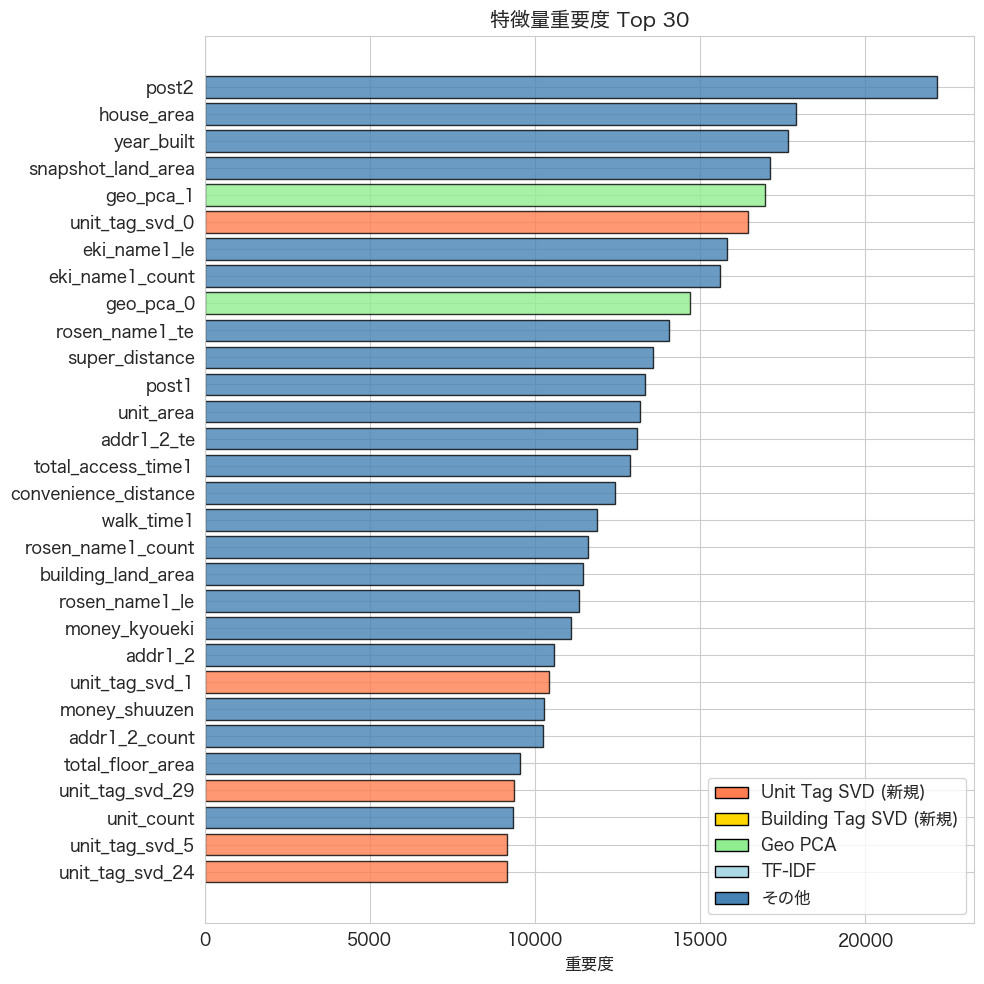

In [10]:
# Top 30 特徴量
top_n = 30
top_features = importance_df.head(top_n)

fig, ax = plt.subplots(figsize=(10, 10))

features = top_features['feature'].to_list()[::-1]
importances = top_features['importance'].to_list()[::-1]

# 色分け: タグSVD特徴量をハイライト
colors = []
for f in features:
    if 'unit_tag_svd' in f:
        colors.append('coral')
    elif 'building_tag_svd' in f:
        colors.append('gold')
    elif 'geo_pca' in f:
        colors.append('lightgreen')
    elif 'tfidf' in f:
        colors.append('lightblue')
    else:
        colors.append('steelblue')

ax.barh(range(len(features)), importances, color=colors, edgecolor='black', alpha=0.8)
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features)
ax.set_xlabel('重要度')
ax.set_title(f'特徴量重要度 Top {top_n}')

# 凡例
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='coral', edgecolor='black', label='Unit Tag SVD (新規)'),
    Patch(facecolor='gold', edgecolor='black', label='Building Tag SVD (新規)'),
    Patch(facecolor='lightgreen', edgecolor='black', label='Geo PCA'),
    Patch(facecolor='lightblue', edgecolor='black', label='TF-IDF'),
    Patch(facecolor='steelblue', edgecolor='black', label='その他'),
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../outputs/feature_importance_top30.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# 特徴量カテゴリ別の重要度合計
def categorize_feature(name):
    if 'unit_tag_svd' in name:
        return 'Unit Tag SVD'
    elif 'building_tag_svd' in name:
        return 'Building Tag SVD'
    elif 'geo_pca' in name:
        return 'Geo PCA'
    elif 'tfidf' in name:
        return 'TF-IDF'
    elif '_te' in name:
        return 'Target Encoding'
    elif '_count' in name:
        return 'Count Encoding'
    elif '_le' in name:
        return 'Label Encoding'
    else:
        return 'Numeric/Other'

importance_pdf = importance_df.to_pandas()
importance_pdf['category'] = importance_pdf['feature'].apply(categorize_feature)

category_importance = importance_pdf.groupby('category')['importance'].agg(['sum', 'mean', 'count'])
category_importance.columns = ['合計重要度', '平均重要度', '特徴量数']
category_importance = category_importance.sort_values('合計重要度', ascending=False)

print("特徴量カテゴリ別重要度:")
print(category_importance.round(0))

特徴量カテゴリ別重要度:
                     合計重要度    平均重要度  特徴量数
category                                 
Numeric/Other     354457.0   5717.0    62
Unit Tag SVD      274873.0   9162.0    30
Building Tag SVD   92151.0   6143.0    15
Count Encoding     82635.0   3443.0    24
Target Encoding    48431.0   6919.0     7
Label Encoding     40164.0  10041.0     4
Geo PCA            31689.0  15844.0     2
TF-IDF              5072.0    254.0    20


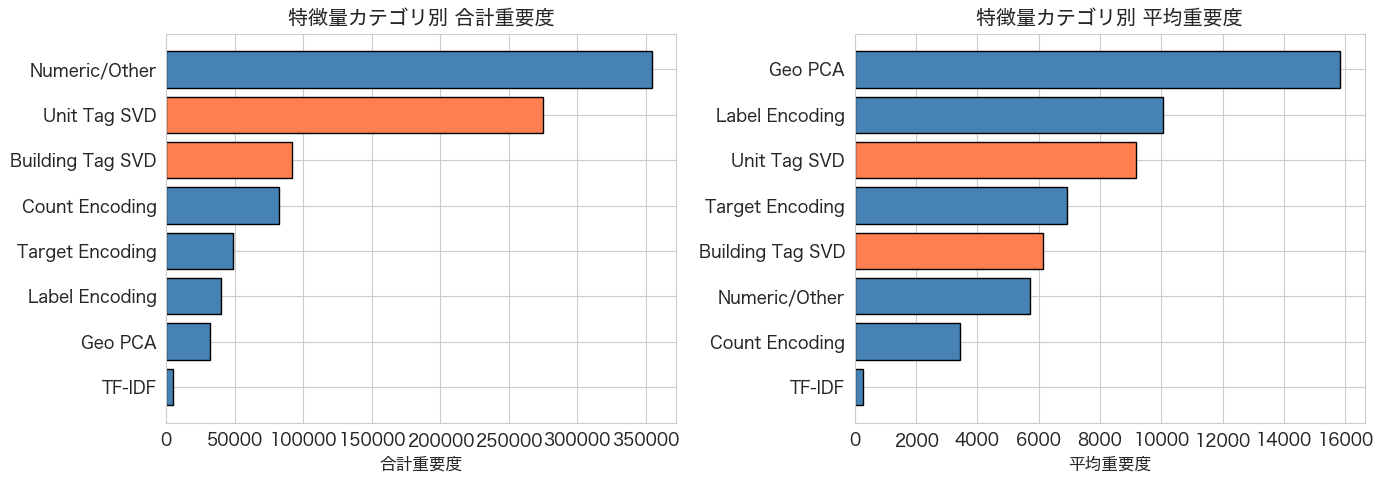

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 合計重要度
ax1 = axes[0]
category_importance_sorted = category_importance.sort_values('合計重要度', ascending=True)
colors_cat = ['coral' if 'Tag SVD' in cat else 'steelblue' for cat in category_importance_sorted.index]
ax1.barh(category_importance_sorted.index, category_importance_sorted['合計重要度'], color=colors_cat, edgecolor='black')
ax1.set_xlabel('合計重要度')
ax1.set_title('特徴量カテゴリ別 合計重要度')

# 平均重要度
ax2 = axes[1]
category_importance_by_mean = category_importance.sort_values('平均重要度', ascending=True)
colors_cat2 = ['coral' if 'Tag SVD' in cat else 'steelblue' for cat in category_importance_by_mean.index]
ax2.barh(category_importance_by_mean.index, category_importance_by_mean['平均重要度'], color=colors_cat2, edgecolor='black')
ax2.set_xlabel('平均重要度')
ax2.set_title('特徴量カテゴリ別 平均重要度')

plt.tight_layout()
plt.savefig('../outputs/category_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. 今後の改善方針

### エラー分析からの知見

| 知見 | 詳細 | 改善案 |
|------|------|--------|
| 高価格帯で誤差大 | 5000万円以上でAPEが高い | 高価格帯専用モデル、価格帯別学習 |
| 過大予測傾向 | 平均PEが正の場合、全体的に高めに予測 | ターゲット変換の見直し |
| タグSVDの有効性 | unit_tag_svd_0が6位、タグ特徴量は有効 | タグの組合せ特徴量追加 |
| 全Fold 15000iter到達 | Early stoppingが効かず | n_estimators増加 (20000+) |

### 短期的改善案 (exp008候補)

1. **n_estimators増加**
   - 現在: 15000 → 提案: 20000-25000
   - 全Foldでearly stoppingが発動していない

2. **タグ組合せ特徴量**
   - building_tag × unit_tag の相互作用
   - 頻出タグ組合せの抽出

3. **価格帯別モデル**
   - 低価格帯 (< 3000万) と高価格帯 (≥ 3000万) で分離
   - スタッキング or ブレンディング

### 中期的改善案

4. **新規特徴量候補**
   - 築年数 × エリア相互作用
   - 周辺相場（地域の平均家賃）
   - 最寄り駅の乗降客数（外部データ）

5. **モデルアンサンブル**
   - LightGBM + XGBoost + CatBoost
   - ニューラルネット（TabNet等）

6. **Pseudo Labeling**
   - テストデータの信頼度高い予測を学習に利用

In [13]:
# 改善効果の見積もり
print("=" * 60)
print("今後の改善効果見積もり")
print("=" * 60)
print(f"")
print(f"現在のCV MAPE: 13.62%")
print(f"")
print(f"改善案別の期待効果:")
print(f"  1. n_estimators増加: -0.1~0.2pt (→ 13.4~13.5%)")
print(f"  2. タグ組合せ特徴量: -0.1~0.3pt (→ 13.3~13.5%)")
print(f"  3. 価格帯別モデル: -0.2~0.5pt (→ 13.1~13.4%)")
print(f"  4. アンサンブル: -0.3~0.5pt (→ 13.1~13.3%)")
print(f"")
print(f"目標: CV MAPE < 13.0%")
print(f"")
print("=" * 60)

今後の改善効果見積もり

現在のCV MAPE: 13.62%

改善案別の期待効果:
  1. n_estimators増加: -0.1~0.2pt (→ 13.4~13.5%)
  2. タグ組合せ特徴量: -0.1~0.3pt (→ 13.3~13.5%)
  3. 価格帯別モデル: -0.2~0.5pt (→ 13.1~13.4%)
  4. アンサンブル: -0.3~0.5pt (→ 13.1~13.3%)

目標: CV MAPE < 13.0%



## 8. サマリー

### 実験結果
- **CV MAPE**: 13.62% (目標 < 14.0% 達成)
- **改善幅**: 0.57pt (exp006比)
- **主要発見**: タグSVD特徴量は有効（unit_tag_svd_0が6位）

### エラー傾向
- 高価格帯 (5000万円以上) でエラーが大きい
- 全体的にやや過大予測傾向

### 次のアクション
1. **exp008**: n_estimators増加 + タグ組合せ特徴量
2. **exp009**: 価格帯別モデル検討
3. **exp010**: アンサンブル検討